In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *

Initialisation of parametres

In [2]:
def sim_run(N, M, para, assemblenum, tstop, teval):

    ### initialised parametres
    para = Paras(N, M)
    p, number = int_preferences(N, M, para.mu_c, assemblenum)
    D = int_conversion(M, para.Dbase, assemblenum)
    l = int_l(M, para.l_base, assemblenum)
    rho = int_rho(M, para.rho_base, assemblenum)
    vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
    m = int_mt(N, para.m_base, assemblenum)

    ## Initialised Initial conditions
    R0 = int_R(M, para.R0, assemblenum)
    C0 = int_C(N, para.w, assemblenum)

    # Load parametres
    para.paras(C0, R0, l, rho, p, vmax, m, D)
    time = np.linspace(0, tstop, teval)
    pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.gamma, para.R_half)
    y0 = np.concatenate((R0, C0)).reshape(M+N,) # initial conditions

    # run and store
    result = solve_ivp(
    odes_scale_size, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)

    Rt = result['y'][0:M]
    Ct = result['y'][M:M+N]
    t = result['t']

    return Rt, Ct, t, para
    

In [3]:
N = 50
M = 100
assemblenum = 1
para = Paras(N, M)

In [4]:
Rt_assemblies = []
Ct_assemblies = []
assemlies = 100
para_assemblies = []

In [5]:
for i in range(assemlies):
    Rt, Ct, t, para = sim_run(N, M, para, i, tstop=3000, teval=10000)
    Rt_assemblies.append(Rt)
    Ct_assemblies.append(Ct)
    para_assemblies.append(para)

In [6]:
t.shape

(10000,)

In [7]:
Rt.shape

(100, 10000)

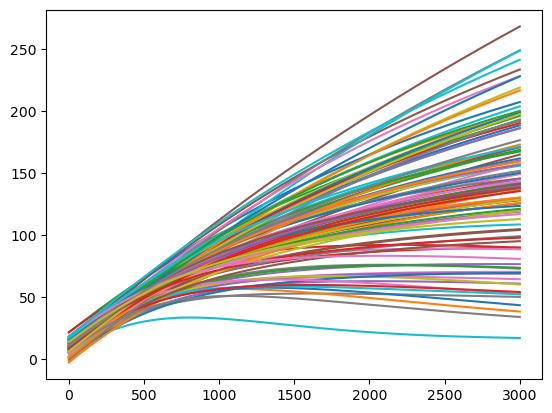

In [8]:
for i in range(M):
    plt.plot(t, Rt[i, :])

In [9]:
# for j in range(100):
#     for i in range(N):
#         Ct = Ct_assemblies[j]
#         plt.plot(t, Ct[i, :])

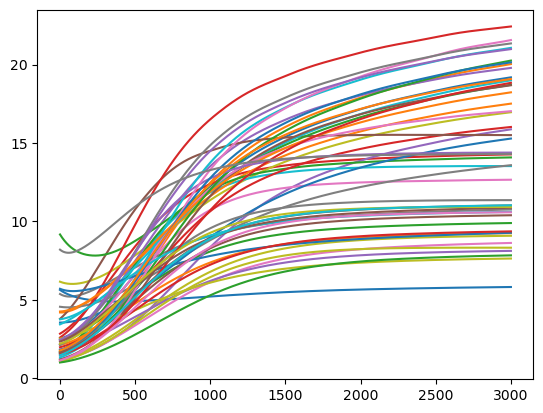

In [10]:
for i in range(N):
        #Ct = Ct_assemblies[j]
        plt.plot(t, Ct[i, :])

In [11]:
Rt.shape

(100, 10000)

In [12]:
species1vg = []

In [13]:
Ct[:, i]

array([2.5556322 , 1.76504542, 2.45925251, 2.9252361 , 1.20453723,
       1.68854284, 1.49522865, 5.29580036, 6.10434311, 1.63163224,
       5.53655212, 4.19196148, 1.77186019, 2.01081506, 2.47938067,
       3.91327229, 1.16882743, 4.53741429, 1.19631768, 3.77897355,
       3.54994428, 2.1501984 , 8.95502758, 2.69375204, 1.85350214,
       1.24492748, 2.40458346, 1.60647313, 2.54614037, 1.3759098 ,
       5.64977826, 4.26387531, 1.66750046, 1.67964994, 2.19241575,
       1.66472621, 1.09825977, 2.19847715, 1.0907829 , 3.49677988,
       1.85614934, 1.823806  , 1.02164287, 1.54451738, 2.50625321,
       2.38719388, 1.17865414, 8.09985632, 2.24151577, 1.51840115])

ValueError: x and y can be no greater than 2D, but have shapes (10000,) and (10000, 50, 1)

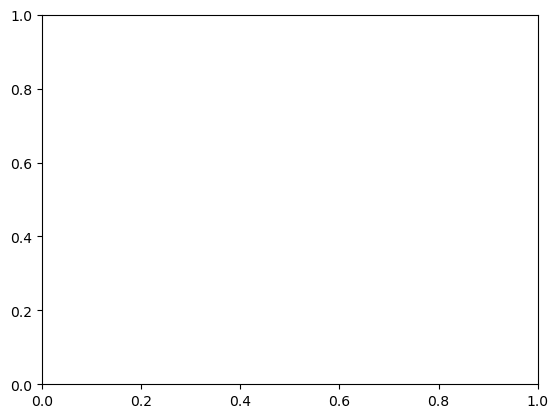

In [16]:
species1vg = []
m1 = []
for i in range(len(t)):
    resourcet = Rt[:, i].reshape(M, 1)
    masst = Ct[:, i].reshape(N, 1)
    v_in = vin(para.p, resourcet, para.R_half, vmax=para.v_in_max, type=2)
    v_in = scale_vin(v_in, masst, para.B0, para.alpha)
    v_g = vgrow(v_in, para.l)[0]
    species1vg.append(v_g)
    print(v_g.shape)
    print(masst.shape)
    m_scale = scale_mt(para.m, masst, para.M0, para.alpha)[0]
    m1.append(m_scale)
    print(m_scale.shape)

plt.plot(t, species1vg)
plt.plot(t, m1)

In [15]:
np.sign(-7)

-1